# Crime_Project
### GeoMapping
* Dependencies and Setup

In [1]:
import gmaps
import numpy as np
import pandas as pd
import gmaps.datasets
import gmaps.geojson_geometries
import matplotlib.pyplot as plt
from matplotlib.cm import viridis, plasma
# from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm
from matplotlib.colors import to_hex

import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context

# Census & gmaps API Keys
from config import census_key, g_key

# Configure gmaps
gmaps.configure(api_key=g_key)
states_geojson = gmaps.geojson_geometries.load_geometry('us-states')
# print(len(states_geojson['features']))
# print(states_geojson['features'][0])

# Import data
data = pd.read_csv('resources/states_2011.csv')
cities_data = pd.read_csv('resources/uscities_data.csv')
cities_geo = cities_data[['Lat', 'Lng']]

In [2]:
# Create GmapsAnalysis Object
class GmapsAnalysis():
  
    # Define initialization method
    def __init__(self, data_df = data, state = 'State', col = 'Crime_Tot', geometry='us-states'):
        # Convert analyzed data values to dict and set the first geometry map layer
        data_dict = data_df.filter([state, col])
        data_dict = data_dict.set_index(state).to_dict()[col]
        self.data = data_dict
        self.min = min(self.data.values())
        self.max = max(self.data.values())
        self.range = self.max - self.min
        self.geojson = gmaps.geojson_geometries.load_geometry(geometry)
        self.fig = gmaps.figure()
        
    def calculate_color(self, state, cmap_color = plasma):
        # We will need to scale the states values to lie between 0 and 1
        # make state a number between 0 and 1
        normalized_state = (state - self.min) / self.range
        # invert state so that high value gives dark color
        inverse_state = 1.0 - normalized_state
        # transform the state value to a matplotlib color
        mpl_color = cmap_color(inverse_state)
        # transform from a matplotlib color to a valid CSS color
        gmaps_color = to_hex(mpl_color, keep_alpha=False)

        return gmaps_color

    def colors_list(self, cmap_color = plasma):
        colors = []
        for feature in self.geojson['features']:
            geo_state_name = feature['properties']['NAME']
            try:
                state = self.data[geo_state_name]
                color = self.calculate_color(state, cmap_color)
            except KeyError:
            # no value for that state: return default color
                color = (0, 0, 0, 0.3)
            colors.append(color)
        return colors

    def color_map(self, cmap_color = plasma, opacity = 0.8):
        states_layer = gmaps.geojson_layer(self.geojson,
                                           fill_color = self.colors_list(cmap_color), stroke_color = self.colors_list(),
                                            fill_opacity = opacity)
        self.fig.add_layer(states_layer)
        
    def symbols_map(self, symbols_data, color = 'blue', scale = 1):
        symbols_layer = gmaps.symbol_layer(symbols_data, fill_color = color, stroke_color = color, scale = scale)
        self.fig.add_layer(symbols_layer)
        
    def marker_map(self, locations = [(41.8781136, -87.6297982)], cont = 'Chicago, IL'):
        marker = gmaps.marker_layer(locations, info_box_content= cont)
        self.fig.add_layer(marker)       

In [3]:
def colorbar_plot(data, color_type = 'plasma'):
    cms = cm.get_cmap(color_type, 256)
    data = [list(data)]
    fig, ax = plt.subplots(1, 1, figsize=(6, 3), constrained_layout=True)
    psm = ax.pcolormesh(data, cmap=cms.reversed(), rasterized=True)
    fig.colorbar(psm, ax=ax)
    plt.show()

### ColorMap for 51 US states based on adjusted rate for Crime and Deaths (location of 788 US cities added on map)

In [4]:
# Creating US states Crime Map
crime = GmapsAnalysis()
crime.color_map(cmap_color = plasma)
# Adding US cities symbols and Chicago infobox
crime.symbols_map(cities_geo, color = 'blue')
crime.marker_map()
crime.fig

Figure(layout=FigureLayout(height='420px'))

![crime_map](images/crime_rate_2011.png)

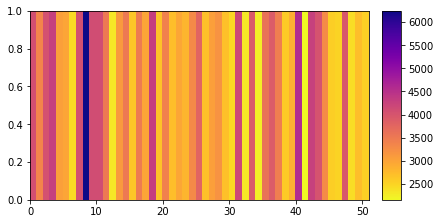

In [5]:
colorbar_plot(crime.data.values(), color_type = 'plasma')

In [6]:
# Creating US states Deaths Map
deaths = GmapsAnalysis(col='All causes')
deaths.color_map(cmap_color = viridis)
# Adding US cities symbols and Chicago infobox
deaths.symbols_map(cities_geo)
deaths.marker_map()
deaths.fig

Figure(layout=FigureLayout(height='420px'))

![deaths_map](images/death_rate_2011.png)

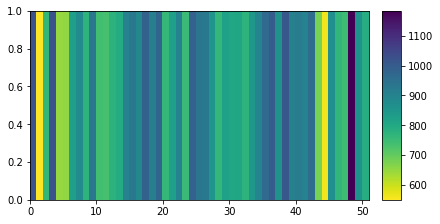

In [7]:
colorbar_plot(deaths.data.values(), color_type = 'viridis')

### HeatingMap for 79 US cities

In [8]:
# import Murders stat Dataset for 79 US cities
murders_data = pd.read_csv('resources/cities_murders.csv')
chicago = murders_data[murders_data['City']=='Chicago']
chicago_locations = chicago[['Lat', 'Lng']]
murders_data.head()

,City,State,2014,2015,% Change,Pop_2014,Pop_2015,2014_adj,2015_adj,Lat,Lng
0,Newark,New Jersey,93,104,11,48283.0,48592.0,192.614378,214.027000,40.735657,-74.172367
1,Jacksonville,Florida,96,97,1,74217.0,74306.0,129.350418,130.541275,30.332184,-81.655651
2,Kansas City,Missouri,78,109,31,150122.0,151502.0,51.957741,71.946245,39.099727,-94.578567
3,St. Louis,Missouri,159,188,29,317399.0,316010.0,50.094676,59.491788,38.627003,-90.199404
4,Baltimore,Maryland,211,344,133,623587.0,622522.0,33.836498,55.259091,39.290385,-76.612189


In [9]:
# Creating DataSet for HeatMap Layers
fig = gmaps.figure()
locations = murders_data[['Lat', 'Lng']]
weight = murders_data['2015']
fig.add_layer(gmaps.heatmap_layer(locations, weights=weight, dissipating=False, max_intensity=30, point_radius=1))
marker_chi = gmaps.marker_layer(chicago_locations,
    info_box_content= 'Chicago,IL 414 murders in 2020')
fig.add_layer(marker_chi)
fig

Figure(layout=FigureLayout(height='420px'))

![crime_map](images/Chicago_Murders.png)